In [29]:
import tensorflow as tf
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal
import neurokit2 as nk
from scipy.ndimage import uniform_filter
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.momentum_iterative_method import momentum_iterative_method
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.tf2.attacks.madry_et_al import madry_et_al
from scipy.signal import butter, filtfilt, lfilter
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
def load_model(model_path):
    if not tf.io.gfile.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} not found.")
    
    model = tf.keras.models.load_model(model_path, compile=False)
    return model

In [3]:
def resample_signal(original_signal, original_fs, target_fs=100):
    if original_fs == target_fs:
        return original_signal
    fs_ratio = target_fs / original_fs
    return signal.resample(original_signal, int(original_signal.shape[0] * fs_ratio))

In [4]:
def adjust_signal_length(signal, target_length):
    """Pad or truncate signal to target length"""
    if signal.shape[0] < target_length:
        return np.pad(signal, ((0, target_length - signal.shape[0]), (0, 0)), mode='constant')
    return signal[:target_length]

In [5]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv1D):
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

In [6]:
def compute_grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        class_output = preds[:, class_idx]
        grads = tape.gradient(class_output, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_output = conv_outputs[0] * pooled_grads  # Removed `.numpy()`

    heatmap = np.mean(conv_output.numpy(), axis=-1)  # Now apply .numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-8)
    
    return heatmap, class_idx.numpy()

In [7]:
def plot_ecg_with_gradcam(signal, heatmap, lead_names, fs, class_idx):
    num_leads = signal.shape[1]
    time = np.arange(signal.shape[0]) / fs
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(num_leads, 1, figure=fig)
    heatmap_normalized = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-8)
    for lead in range(num_leads):
        ax = fig.add_subplot(gs[lead, 0])
        vertical_offset = lead * 3
        ax.plot(time, signal[:, lead] + vertical_offset, linewidth=1, color='black')
        heatmap_extent = [time[0], time[-1], vertical_offset - 1.5, vertical_offset + 1.5]
        ax.imshow(
            np.expand_dims(heatmap_normalized, axis=0),
            cmap='viridis',
            aspect='auto',
            extent=heatmap_extent,
            alpha=0.4,
            origin='lower'
        )
        ax.set_ylabel(lead_names[lead], rotation=0, ha='right', va='center')
        ax.set_yticks([])
        ax.set_ylim(vertical_offset - 2, vertical_offset + 2)
        if lead != num_leads - 1:
            ax.set_xticks([])
    plt.suptitle(f"Predicted Class: {class_idx}\nGrad-CAM Heatmap Overlay", y=0.92)
    plt.xlabel("Time (seconds)")
    plt.tight_layout()
    plt.show()

In [8]:
#Helper
def get_header_file(record):
    if not record.endswith('.hea'):
        header_file = record + '.hea'
    else:
        header_file = record
    return header_file

def load_text(filename):
    with open(filename, 'r') as f:
        string = f.read()
    return string

def load_header(record):
    header_file = get_header_file(record)
    header = load_text(header_file)
    return header

def load_signals(record):
    signal, fields = wfdb.rdsamp(record)
    return signal, fields

def get_variable(string, variable_name):
    variable = ''
    has_variable = False
    for l in string.split('\n'):
        if l.startswith(variable_name):
            variable = l[len(variable_name):].strip()
            has_variable = True
    return variable, has_variable

def remove_extra_characters(x):
    x = str(x)
    x = x.replace('"', '').replace("'", "")
    x = x.replace('(', '').replace(')', '').replace('[', '').replace(']', '').replace('{', '').replace('}', '')
    x = x.replace(' ', '').replace('\t', '')
    x = x.strip()
    return x

def is_number(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

def sanitize_boolean_value(x):
    x = remove_extra_characters(x)
    if (is_number(x) and float(x)==0) or (remove_extra_characters(x).casefold() in ('false', 'f', 'no', 'n')):
        return 0
    elif (is_number(x) and float(x)==1) or (remove_extra_characters(x).casefold() in ('true', 't', 'yes', 'y')):
        return 1
    else:
        return float('nan')

def get_label(string, allow_missing=False):
    label, has_label = get_variable(string, label_string)
    if not has_label and not allow_missing:
        raise Exception('No label is available: are you trying to load the labels from the held-out data?')
    label = sanitize_boolean_value(label)
    return label

def load_label(record):
    header = load_header(record)
    label = get_label(header)
    return label

In [9]:
# Configuration
MODEL_PATH = "./model/model.keras"
RECORD_PATH = "./input/11134"
REQUIRED_LENGTH = 1000
NUM_SAMPLES_TO_PLOT = 1
TARGET_FS = 100

In [10]:
model = load_model(MODEL_PATH)
ecg , text= load_signals(RECORD_PATH)
fs = int(text["fs"])
conv_layer_name = find_last_conv_layer(model)
original_signal = ecg
original_fs = int(text["fs"])
if original_signal.ndim != 2 or original_signal.shape[1] != 12:
        raise ValueError("ECG signal must have shape (samples, 12 leads).")

Resampled samples: 733, Target FS: 100
Original Signal - Predicted Class: 0


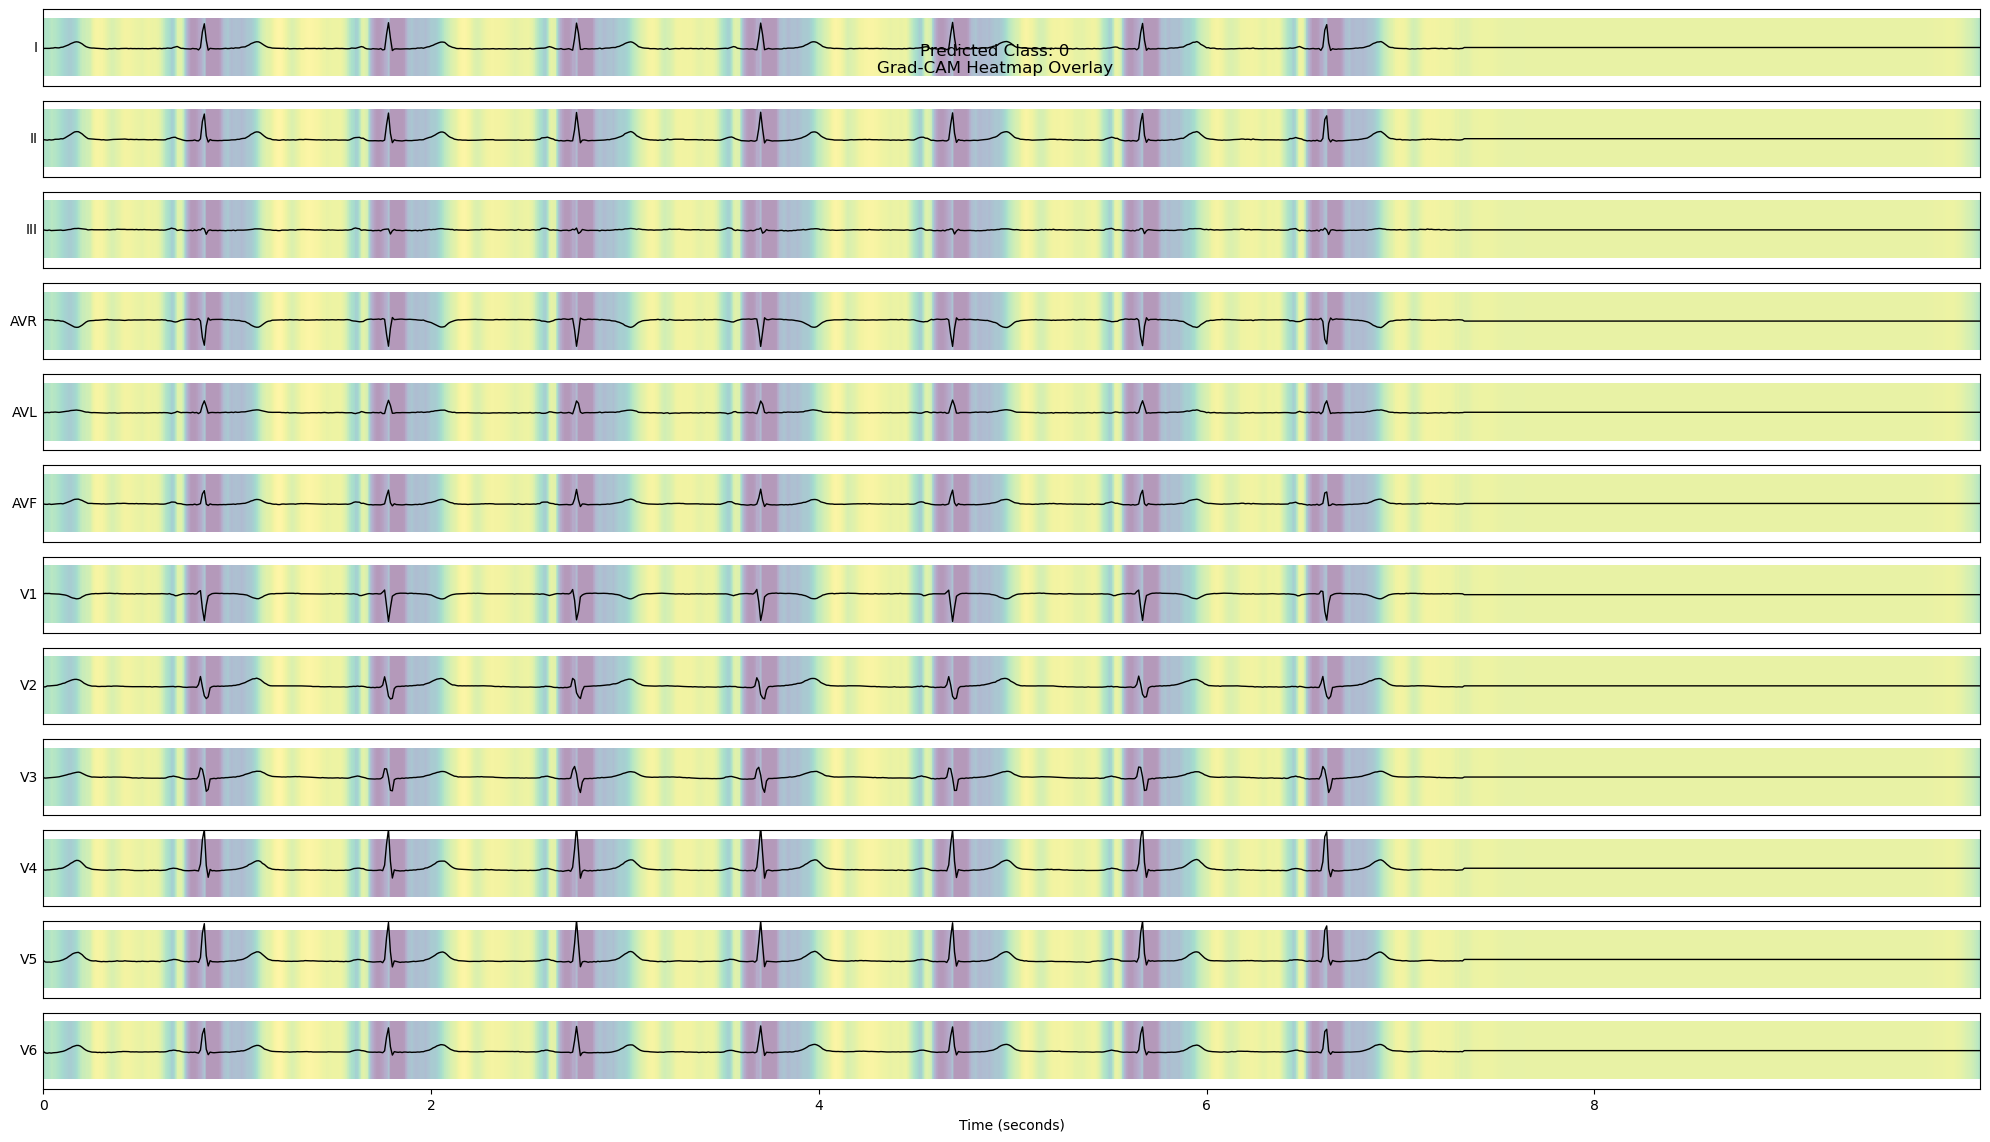

In [11]:
try:    
    # Resample and process signal
    resampled_signal = resample_signal(original_signal, original_fs, TARGET_FS)
    total_samples = resampled_signal.shape[0]
    
    print(f"Resampled samples: {total_samples}, Target FS: {TARGET_FS}")
    
    adjusted_signal = adjust_signal_length(resampled_signal, REQUIRED_LENGTH)
    
    input_tensor = tf.convert_to_tensor(
        np.expand_dims(adjusted_signal, 0), dtype=tf.float32
    )
    
    # Compute Grad-CAM
    heatmap_original, class_idx_original = compute_grad_cam(model, input_tensor, conv_layer_name)
    
    # Plot Grad-CAM
    print(f"Original Signal - Predicted Class: {class_idx_original}")
    plot_ecg_with_gradcam(
        adjusted_signal,
        heatmap_original,
        text['sig_name'],
        TARGET_FS,
        class_idx=class_idx_original)
        
except Exception as main_error:
    print(f"Critical error: {str(main_error)}")

In [12]:
probability_output = model.predict(input_tensor)

print("Predicted probabilities:", probability_output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Predicted probabilities: [[0.01365036]]


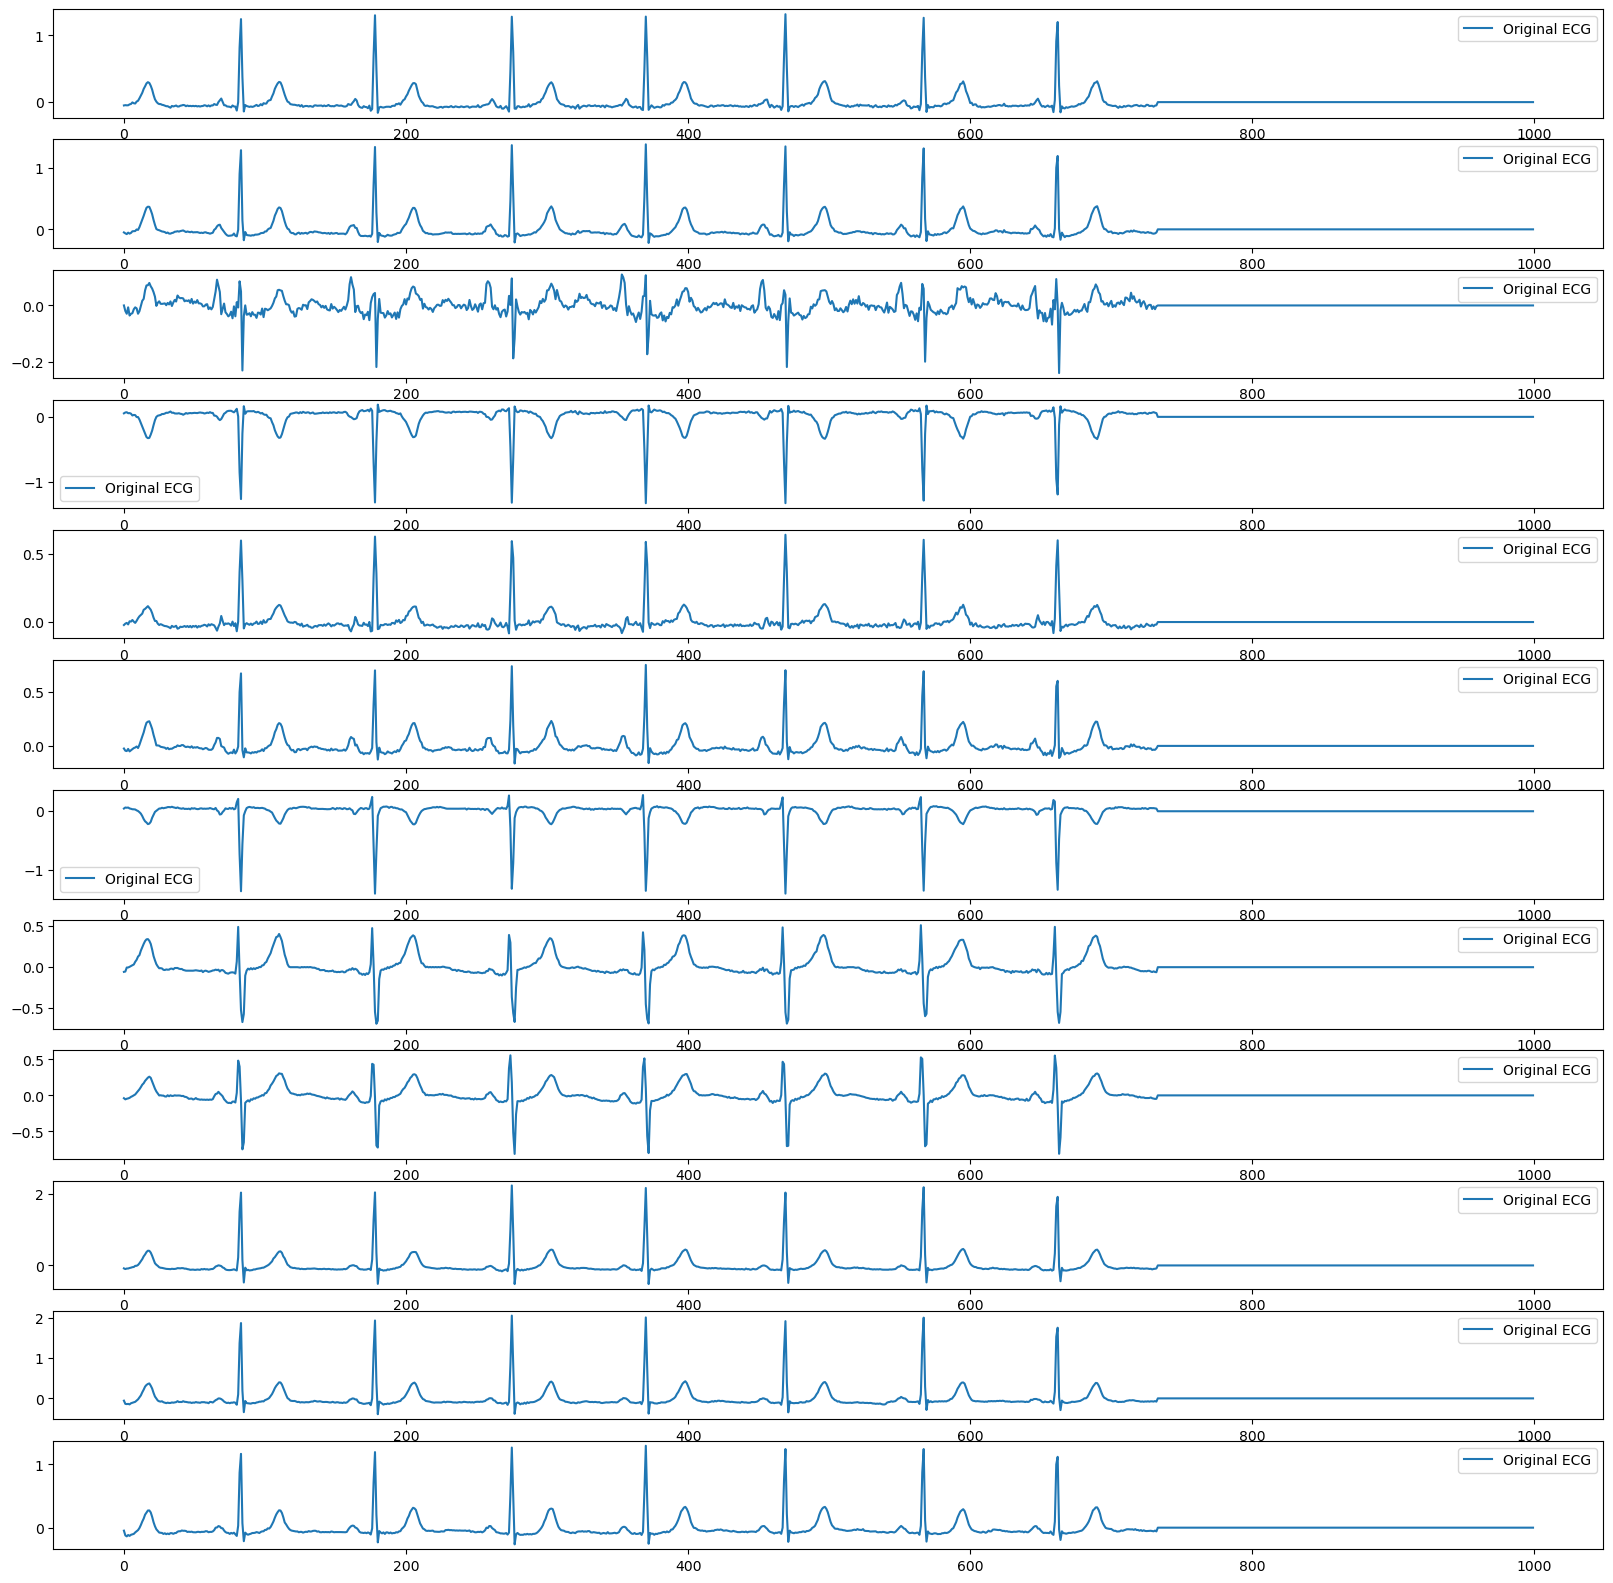

In [13]:
plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.asarray(adjusted_signal)[:,i], label= "Original ECG")
    plt.legend()

In [14]:
def optimize_linear(grad, eps):

    axis = list(range(1, len(grad.get_shape())))
    avoid_zero_div = 1e-12

    # Take sign of gradient
    optimal_perturbation = tf.sign(grad)
    optimal_perturbation = tf.stop_gradient(optimal_perturbation)
    scaled_perturbation = tf.multiply(eps, optimal_perturbation)
    
    return scaled_perturbation

In [15]:
def bandpass_filter(signal, lowcut=0.5, highcut=50, fs=500, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

In [16]:
num_epochs = 100
eps = 0.01
data_example = np.expand_dims(adjusted_signal,0)
#pred_example = y_data
desired_pred = np.array([[1]])

data_example = tf.convert_to_tensor(data_example, dtype=tf.float32)

adv_x = data_example

while model.predict(adv_x)[0][0] < 0.01:
    print(model.predict(adv_x))
    with tf.GradientTape() as tape:
      tape.watch(adv_x)
      pred = model(adv_x)
      loss = tf.keras.losses.binary_crossentropy(desired_pred, pred)
      loss = -loss
      #print(np.asarray(loss))
    grads = tape.gradient(loss, adv_x)
    #print(grads)
    optimal_perturbation = optimize_linear(grads, eps)
    #optimal_perturbation = uniform_filter(optimal_perturbation[0], 15, mode='constant')
    print(optimal_perturbation.shape)
    optimal_perturbation_filtered = np.array([bandpass_filter(optimal_perturbation[0,:,i], fs=fs) for i in range(12)])
    optimal_perturbation_filtered = np.expand_dims(np.moveaxis(optimal_perturbation_filtered,0,-1),0)
    #print(optimal_perturbation)
    # Add perturbation to original example to obtain adversarial example
    adv_x = adv_x + optimal_perturbation_filtered

    adv_x = tf.convert_to_tensor(adv_x)
    # Ensure plausible values (might be something else than -2 to 5)
    #adv_x = tf.clip_by_value(adv_x, -2,5)

    #opt.apply_gradients(zip(grads, model.trainable_variables))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


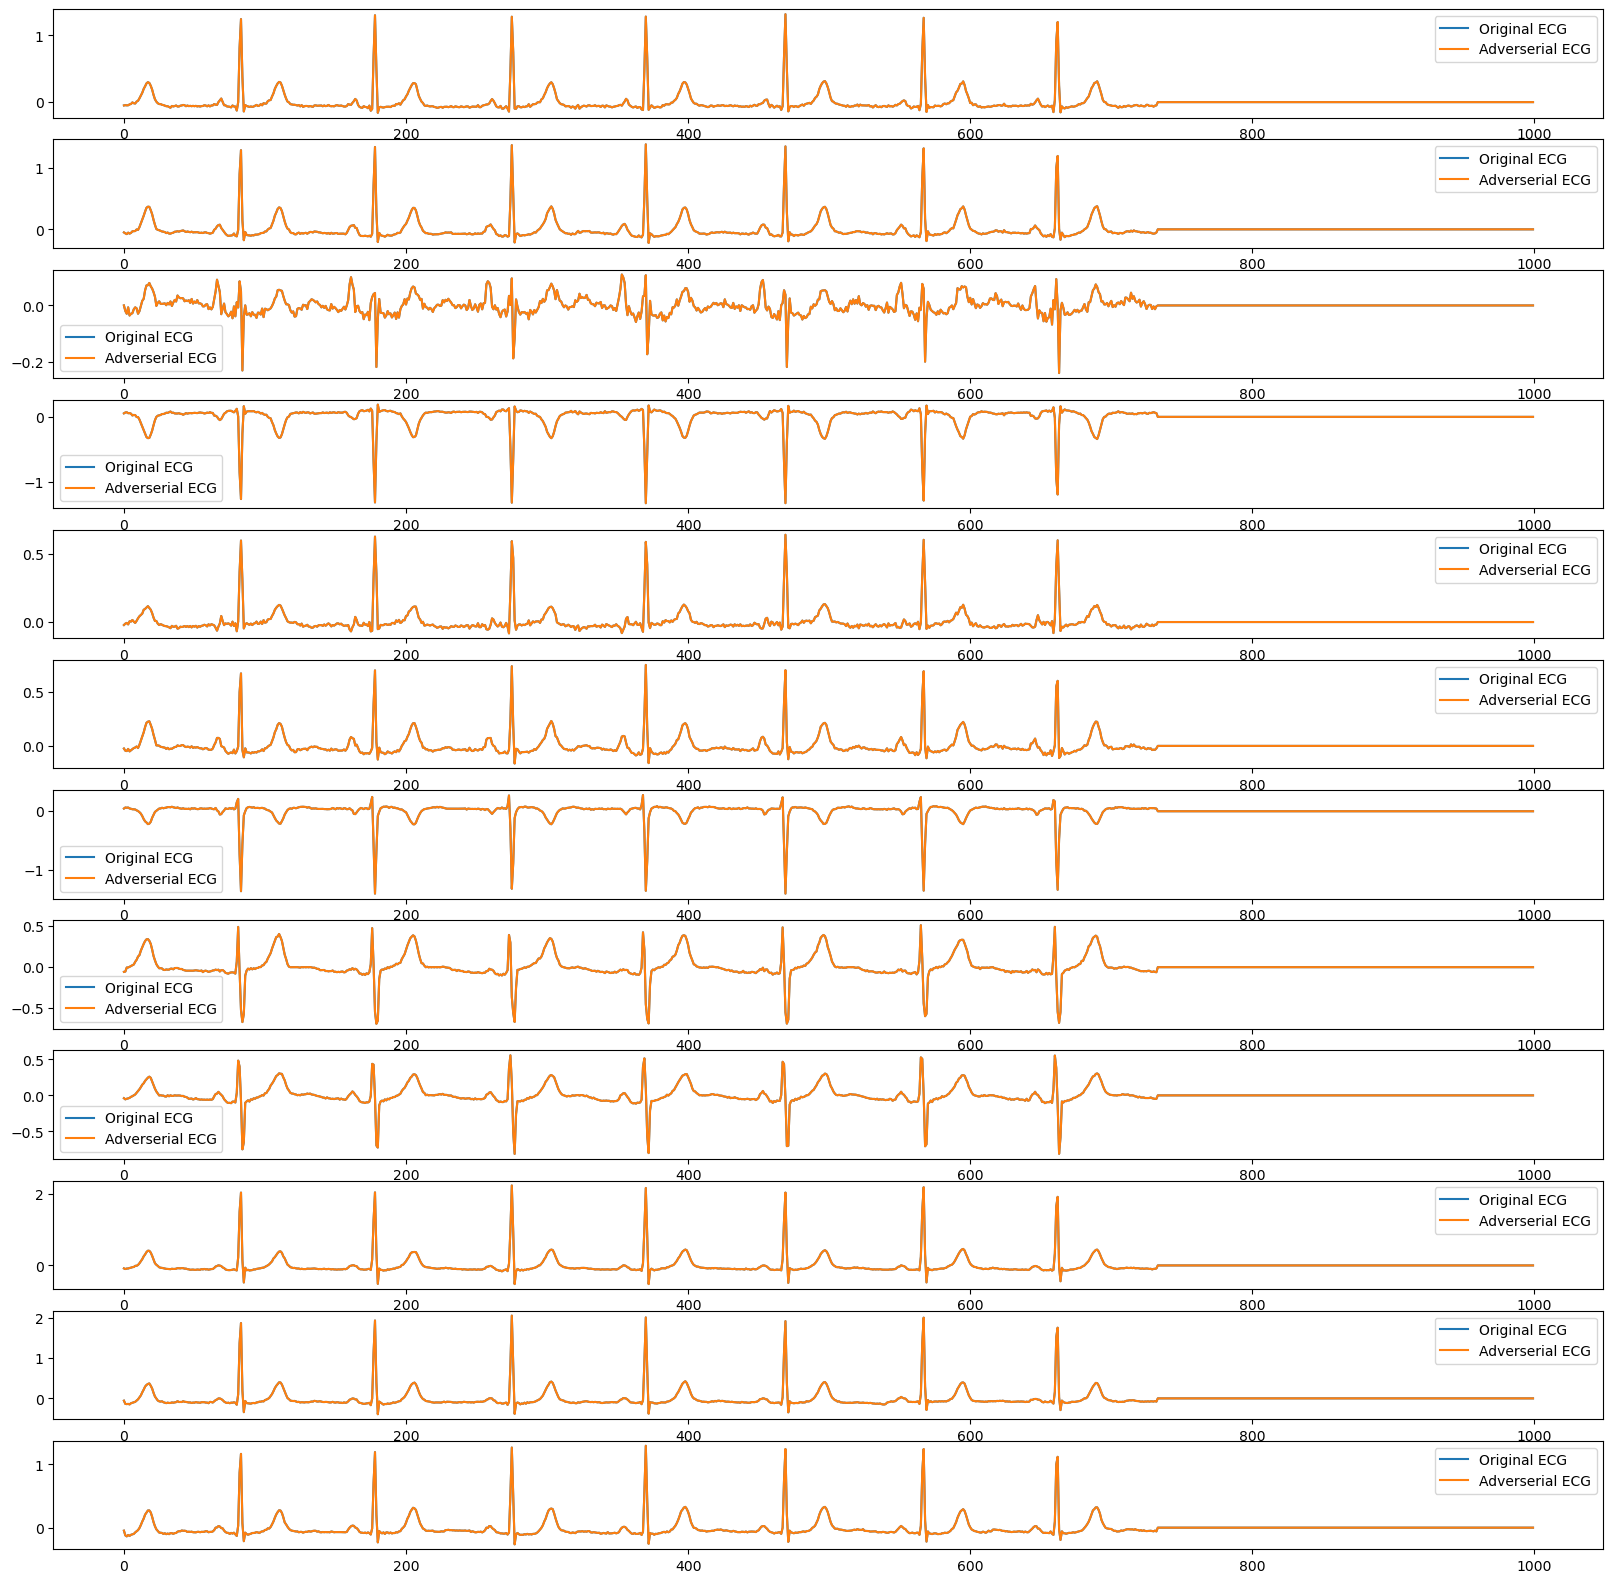

In [17]:
plt.figure(figsize=(20,20))
#adv_x = bandpass_filter(adv_x)
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.asarray(data_example)[0,:,i], label= "Original ECG")
    plt.plot(np.asarray(adv_x)[0,:,i], label= "Adverserial ECG")
    plt.legend()

In [18]:
original_pred = model.predict(input_tensor)
print("Original Prediction:", original_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Original Prediction: [[0.01365036]]


In [19]:
original_pred

array([[0.01365036]], dtype=float32)

In [20]:
input_tensor.shape

TensorShape([1, 1000, 12])

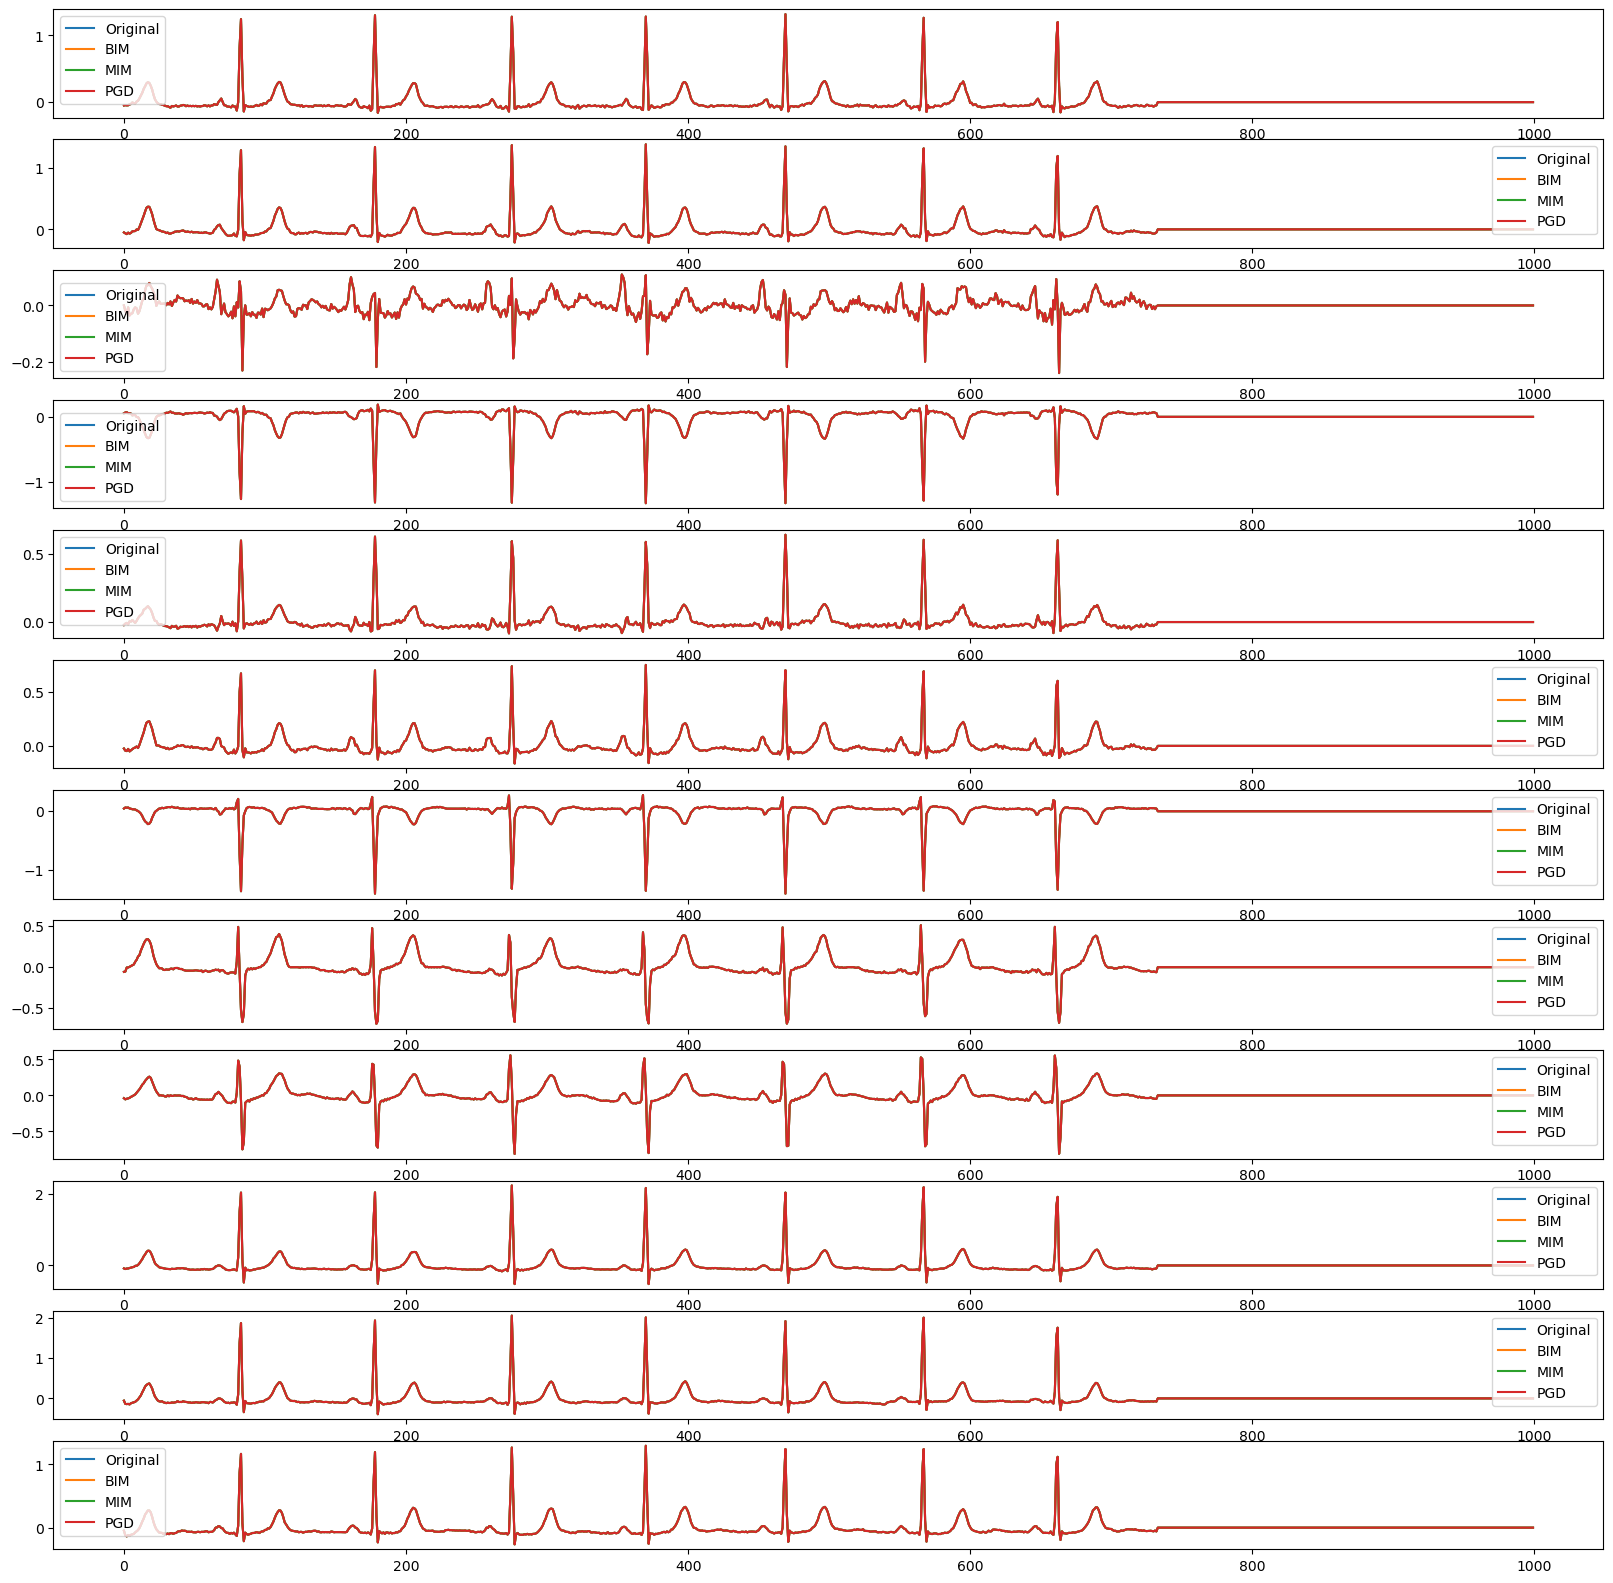

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Original: [[0.01365036]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
BIM: [[0.01365036]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MIM: [[0.01365036]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PGD: [[0.01365036]]


In [21]:
# Attack parameters
true_label = tf.constant([0], dtype=tf.int64)  # Update with actual label
eps = 0.01
alpha = eps / 10
steps = 10

# Generate adversarial examples
adv_bim = projected_gradient_descent(model, input_tensor, eps, alpha, steps, np.inf, y=true_label)
adv_mim = momentum_iterative_method(model, input_tensor, eps, alpha, steps, decay_factor=1.0)
adv_pgd = projected_gradient_descent(model, input_tensor, eps, alpha, steps, np.inf, y=true_label)

# Visualization
plt.figure(figsize=(20, 20))
for i in range(12):
    plt.subplot(12, 1, i+1)
    plt.plot(adjusted_signal[:, i], label="Original")
    plt.plot(adv_bim.numpy()[0, :, i], label="BIM")
    plt.plot(adv_mim.numpy()[0, :, i], label="MIM")
    plt.plot(adv_pgd.numpy()[0, :, i], label="PGD")
    plt.legend()
plt.show()

# Predictions
print("Original:", model.predict(input_tensor))
print("BIM:", model.predict(adv_bim))
print("MIM:", model.predict(adv_mim))
print("PGD:", model.predict(adv_pgd))

In [22]:
def extract_average_beat(signal_lead, sampling_rate):
    """Extract and average ECG beats using NeuroKit"""
    cleaned = nk.ecg_clean(signal_lead, sampling_rate=sampling_rate)
    _, rpeaks = nk.ecg_peaks(cleaned, sampling_rate=sampling_rate)
    
    if len(rpeaks["ECG_R_Peaks"]) == 0:
        raise ValueError("No R-peaks detected")
        
    segments = nk.ecg_segment(cleaned, rpeaks=rpeaks["ECG_R_Peaks"], 
                            sampling_rate=sampling_rate)
    beat_keys = [k for k in segments.keys() if k != 'Segment_0']
    return np.mean([segments[k]["Signal"] for k in beat_keys], axis=0)

In [23]:
def plot_comparison(original, adversarial, lead_names, title):
    """Plot original vs adversarial comparison"""
    plt.figure(figsize=(20, 12))
    for i in range(12):
        plt.subplot(12, 1, i+1)
        plt.plot(original[:, i], label="Original")
        plt.plot(adversarial[:, i], label="Adversarial")
        plt.ylabel(lead_names[i], rotation=0, ha='right')
        plt.yticks([])
        if i != 11: plt.xticks([])
    plt.suptitle(title)
    plt.legend()
    plt.show()

In [30]:
# Generate adversarial examples dictionary
attacks = {
    "bim": adv_bim,
    "mim": adv_mim,
    "pgd": adv_pgd
}

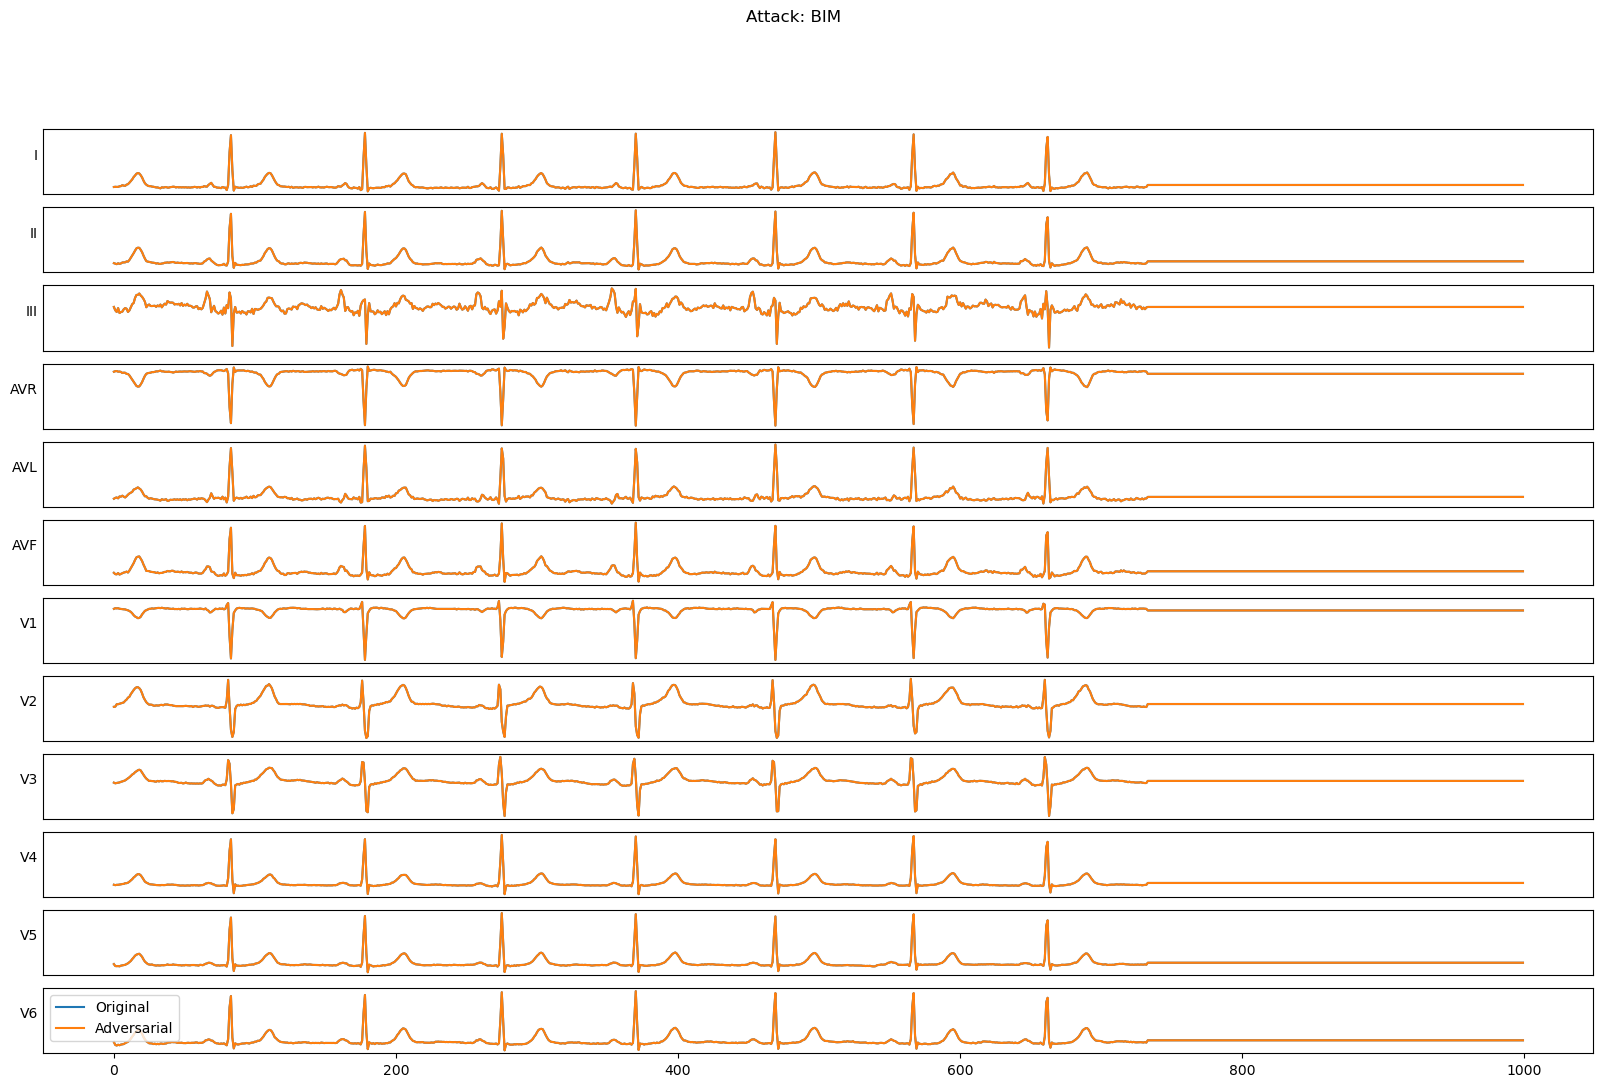

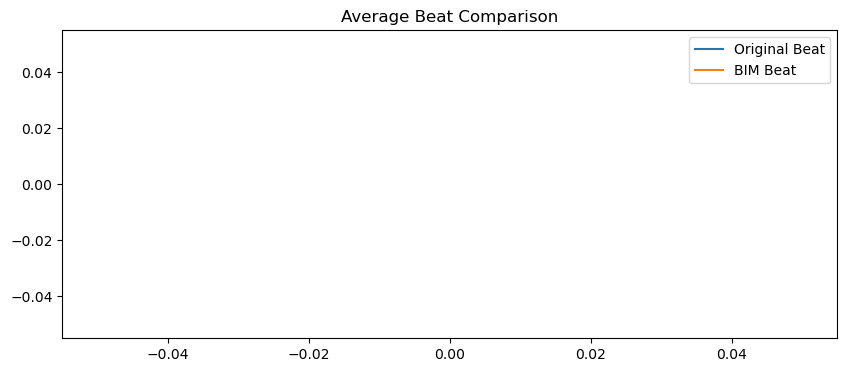

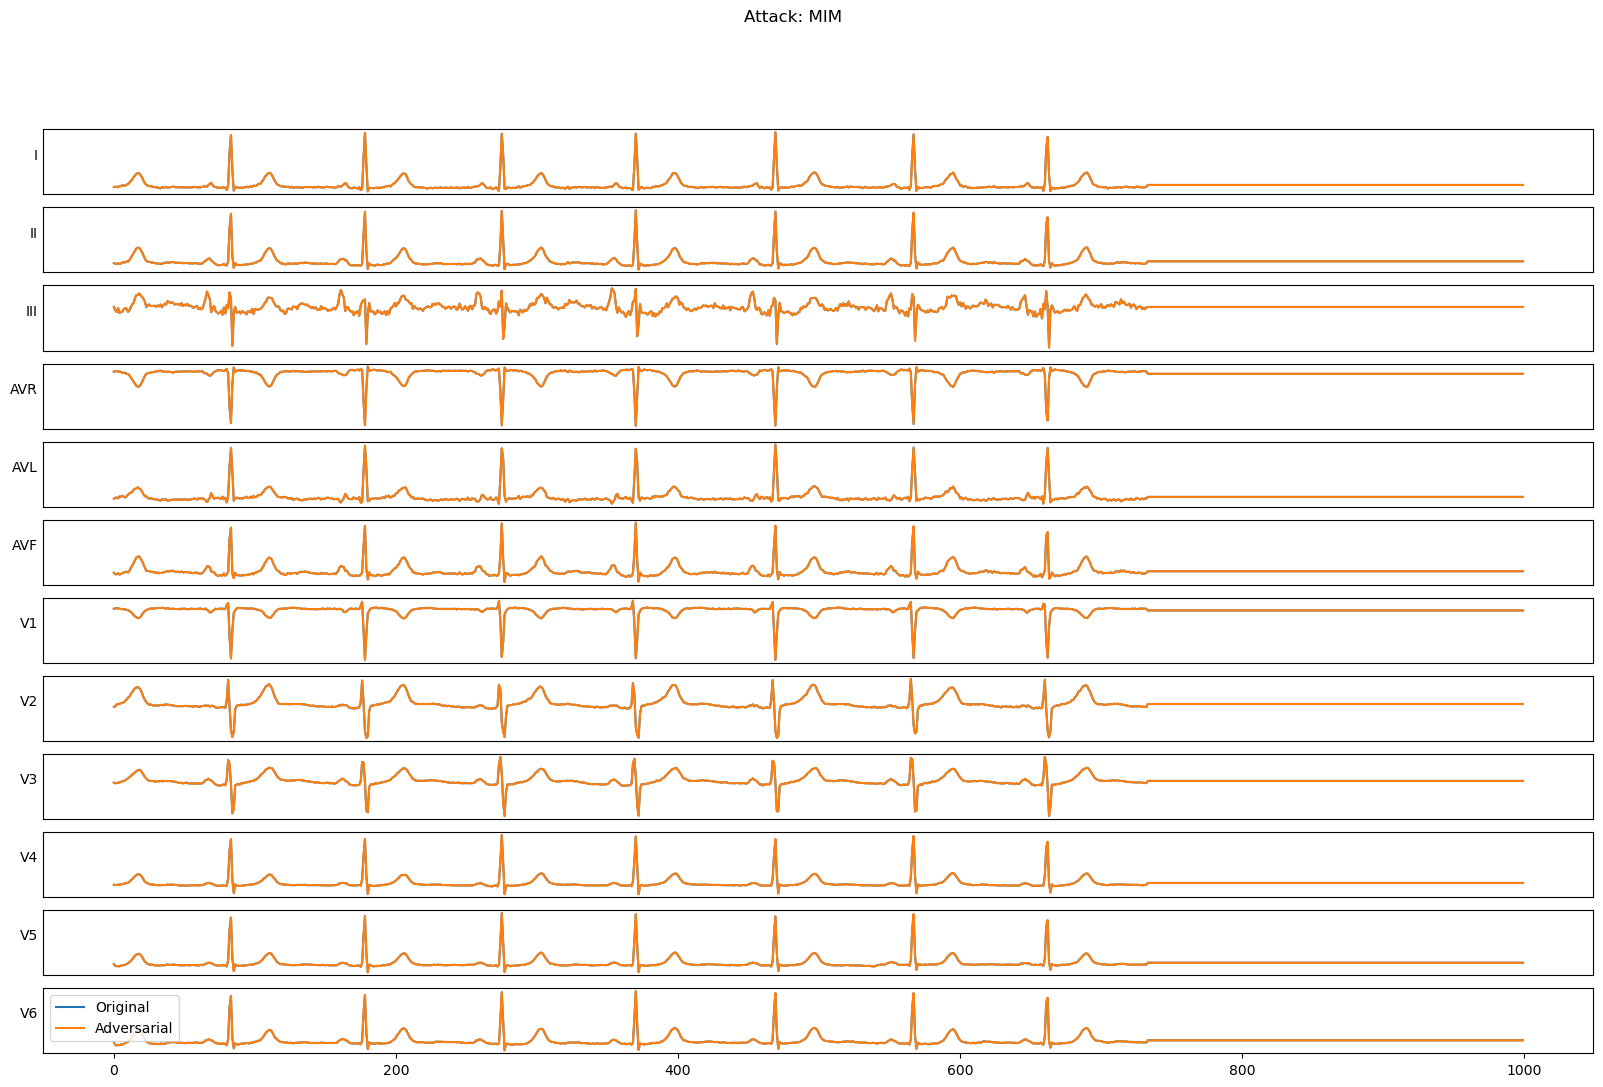

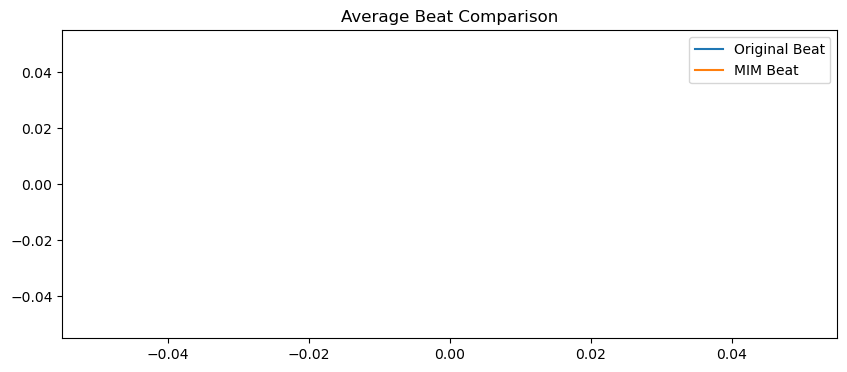

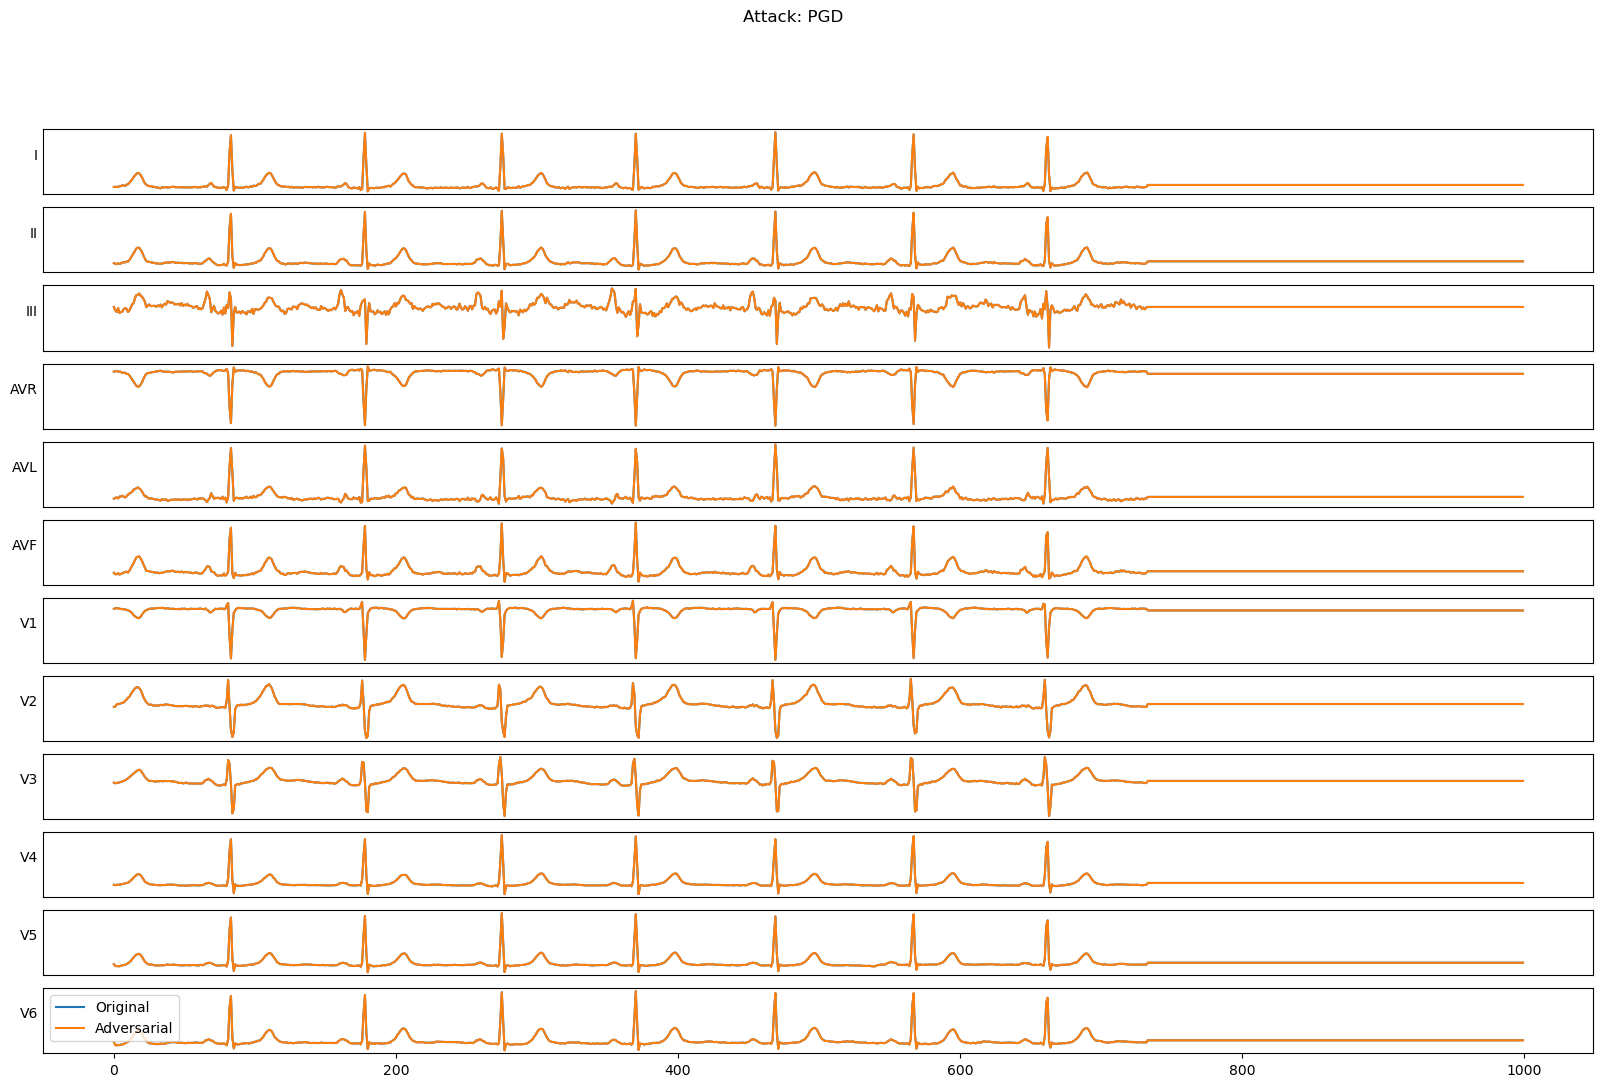

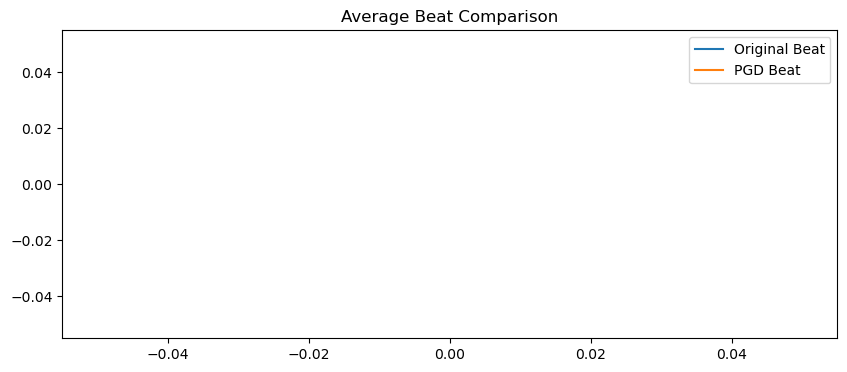

In [33]:
# Visualization and analysis
for name, adv_example in attacks.items():
    plot_comparison(adjusted_signal,  # Use actual variable
                  adv_example.numpy()[0], 
                  text['sig_name'], 
                  f"Attack: {name.upper()}")
    
    # Beat extraction and comparison
    try:
        orig_beat = extract_average_beat(adjusted_signal[:, 1], TARGET_FS)
        adv_beat = extract_average_beat(adv_example.numpy()[0, :, 1], TARGET_FS)
        
        plt.figure(figsize=(10, 4))
        plt.plot(orig_beat, label="Original Beat")
        plt.plot(adv_beat, label=f"{name.upper()} Beat")
        plt.title("Average Beat Comparison")
        plt.legend()
        plt.show()
        
    except ValueError as e:
        print(f"Beat comparison failed: {e}")